In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [13]:
df_merged = pd.read_csv('emissions_gdp_population_merged.csv')

In [14]:
df_merged.head()

,ISO,Country,Year,Total_Emissions,GDP,Population,GDP_growth_1yr,Population_growth_1yr,GDP_per_capita,Emissions_lag_1,Emissions_lag_2,Emissions_lag_3,Emissions_growth_1yr,Emissions_per_capita,Emissions_intensity
0,AGO,Angola,1993,72.68,5.768720e+09,12827135.0,-0.305627,403423.0,449.727895,69.75,68.92,68.49,0.042007,0.000006,1.259898e-08
1,AGO,Angola,1994,75.64,4.438321e+09,13249764.0,-0.230623,422629.0,334.973590,72.68,69.75,68.92,0.040726,0.000006,1.704248e-08
2,AGO,Angola,1995,78.78,5.538749e+09,13699778.0,0.247938,450014.0,404.294818,75.64,72.68,69.75,0.041512,0.000006,1.422343e-08
3,AGO,Angola,1996,81.71,7.526422e+09,14170973.0,0.358867,471195.0,531.115367,78.78,75.64,72.68,0.037192,0.000006,1.085642e-08
4,AGO,Angola,1997,80.81,7.648380e+09,14660413.0,0.016204,489440.0,521.702915,81.71,78.78,75.64,-0.011015,0.000006,1.056564e-08


In [15]:
# ============================================================================
# STEP 1: Train Lasso Model on Full Data
# ============================================================================

# Define features
emission_features = [
    'GDP', 'GDP_growth_1yr', 'GDP_per_capita',
    'Population', 'Population_growth_1yr',
    'Emissions_lag_1', 'Emissions_lag_2', 'Emissions_lag_3',
    'Emissions_growth_1yr', 'Emissions_per_capita', 'Emissions_intensity'
]

target = 'Total_Emissions'

# Prepare data
X = df_merged[emission_features]
y = df_merged[target]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Lasso model
lasso_model = Lasso(alpha=1.0, max_iter=10000)
lasso_model.fit(X_scaled, y)

print(" Lasso model trained successfully!")
print(f"   R² on training data: {lasso_model.score(X_scaled, y):.4f}")

 Lasso model trained successfully!
   R² on training data: 0.9971


In [16]:
# ============================================================================
# STEP 2: Prepare for Future Predictions (2021-2030)
# ============================================================================

# Get the last available year in the data
last_data_year = df_merged['Year'].max()
print(f"\n Last year in data: {last_data_year}")
print(f" Predicting for years: 2021-2030")

# Get unique countries
countries = df_merged['ISO'].unique()
print(f" Number of countries: {len(countries)}")


# Store all predictions
all_predictions = []


 Last year in data: 2020
 Predicting for years: 2021-2030
 Number of countries: 153


In [17]:
# ============================================================================
# STEP 3: Predict Emissions for Each Country (2021-2030)
# ============================================================================

print("\n Generating predictions...")

for country in countries:
    # Get this country's historical data
    country_df = df_merged[df_merged['ISO'] == country].sort_values('Year')
    
    if country_df.empty:
        continue
    
    # Get the last row with actual data
    last_row = country_df.iloc[-1].copy()
    country_name = last_row['Country']
    last_year = int(last_row['Year'])
    
    # Start predicting from max(last_year+1, 2021) to 2030
    start_year = max(last_year + 1, 2021)
    
    # If data already goes beyond 2020, use it
    if last_year >= 2020:
        current_emissions = last_row['Total_Emissions']
        current_gdp = last_row['GDP']
        current_pop = last_row['Population']
    else:
        # Use 2020 data if available
        continue
    
    for year in range(start_year, 2031):
        # Assume modest growth rates for GDP and Population (you can adjust these)
        gdp_growth = 0.025  # 2.5% annual GDP growth
        pop_growth = 0.01   # 1% annual population growth
        
        # Update GDP and Population
        new_gdp = last_row['GDP'] * (1 + gdp_growth)
        new_pop = last_row['Population'] * (1 + pop_growth)
        
        # Calculate features for prediction
        features = {
            'GDP': new_gdp,
            'GDP_growth_1yr': gdp_growth,
            'GDP_per_capita': new_gdp / new_pop if new_pop > 0 else 0,
            'Population': new_pop,
            'Population_growth_1yr': pop_growth,
            'Emissions_lag_1': last_row['Total_Emissions'] if 'Total_Emissions' in last_row else last_row['Emissions_lag_1'],
            'Emissions_lag_2': last_row['Emissions_lag_1'],
            'Emissions_lag_3': last_row['Emissions_lag_2'],
            'Emissions_growth_1yr': last_row['Emissions_growth_1yr'],
            'Emissions_per_capita': last_row['Total_Emissions'] / new_pop if new_pop > 0 else 0,
            'Emissions_intensity': last_row['Total_Emissions'] / new_gdp if new_gdp > 0 else 0
        }
        
        # Create feature array and scale
        X_pred = np.array([[features[f] for f in emission_features]])
        X_pred_scaled = scaler.transform(X_pred)
        
        # Predict emissions
        pred_emissions = lasso_model.predict(X_pred_scaled)[0]
        
        # Ensure non-negative emissions
        pred_emissions = max(0, pred_emissions)
        
        # Store prediction
        all_predictions.append({
            'ISO': country,
            'Country': country_name,
            'Year': year,
            'Predicted_Emissions': pred_emissions,
            'GDP': new_gdp,
            'Population': new_pop
        })
        
        # Update last_row for next iteration
        last_row['Emissions_lag_3'] = last_row['Emissions_lag_2']
        last_row['Emissions_lag_2'] = last_row['Emissions_lag_1']
        last_row['Emissions_lag_1'] = pred_emissions
        last_row['Total_Emissions'] = pred_emissions
        last_row['GDP'] = new_gdp
        last_row['Population'] = new_pop
        last_row['Emissions_growth_1yr'] = (pred_emissions - last_row['Emissions_lag_2']) / last_row['Emissions_lag_2'] if last_row['Emissions_lag_2'] > 0 else 0
        last_row['Year'] = year


 Generating predictions...


In [18]:
# ============================================================================
# STEP 4: Create Predictions DataFrame
# ============================================================================

predictions_df = pd.DataFrame(all_predictions)

print(f"\n Generated {len(predictions_df)} predictions")
print(f"   Countries: {predictions_df['ISO'].nunique()}")
print(f"   Years: {predictions_df['Year'].min()} - {predictions_df['Year'].max()}")


 Generated 1530 predictions
   Countries: 153
   Years: 2021 - 2030


In [19]:
# ============================================================================
# STEP 5: Save to CSV
# ============================================================================

predictions_df.to_csv('emissions_predictions_2021_2030.csv', index=False)
print("\n Saved to: emissions_predictions_2021_2030.csv")



 Saved to: emissions_predictions_2021_2030.csv


In [20]:
# ============================================================================
# STEP 6: Top 10 Emitters by 2030
# ============================================================================

print("\n" + "="*70)
print(" TOP 10 COUNTRIES BY PREDICTED EMISSIONS IN 2030")
print("="*70)

top10_2030 = predictions_df[predictions_df['Year'] == 2030].nlargest(10, 'Predicted_Emissions')
top10_2030 = top10_2030[['Country', 'ISO', 'Predicted_Emissions']].reset_index(drop=True)
top10_2030.index = top10_2030.index + 1  # Start ranking from 1
top10_2030['Predicted_Emissions'] = top10_2030['Predicted_Emissions'].apply(lambda x: f"{x:,.2f}")

print(top10_2030.to_string())


 TOP 10 COUNTRIES BY PREDICTED EMISSIONS IN 2030
                             Country  ISO Predicted_Emissions
1                              China  CHN           14,910.26
2                              India  IND            5,264.27
3                      United States  USA            4,227.59
4                             Russia  RUS            2,108.45
5                          Indonesia  IDN            1,972.37
6                             Brazil  BRA            1,738.57
7                               Iran  IRN            1,046.53
8   Democratic Republic of the Congo  COD              929.47
9                              Japan  JPN              803.71
10                          Pakistan  PAK              784.98


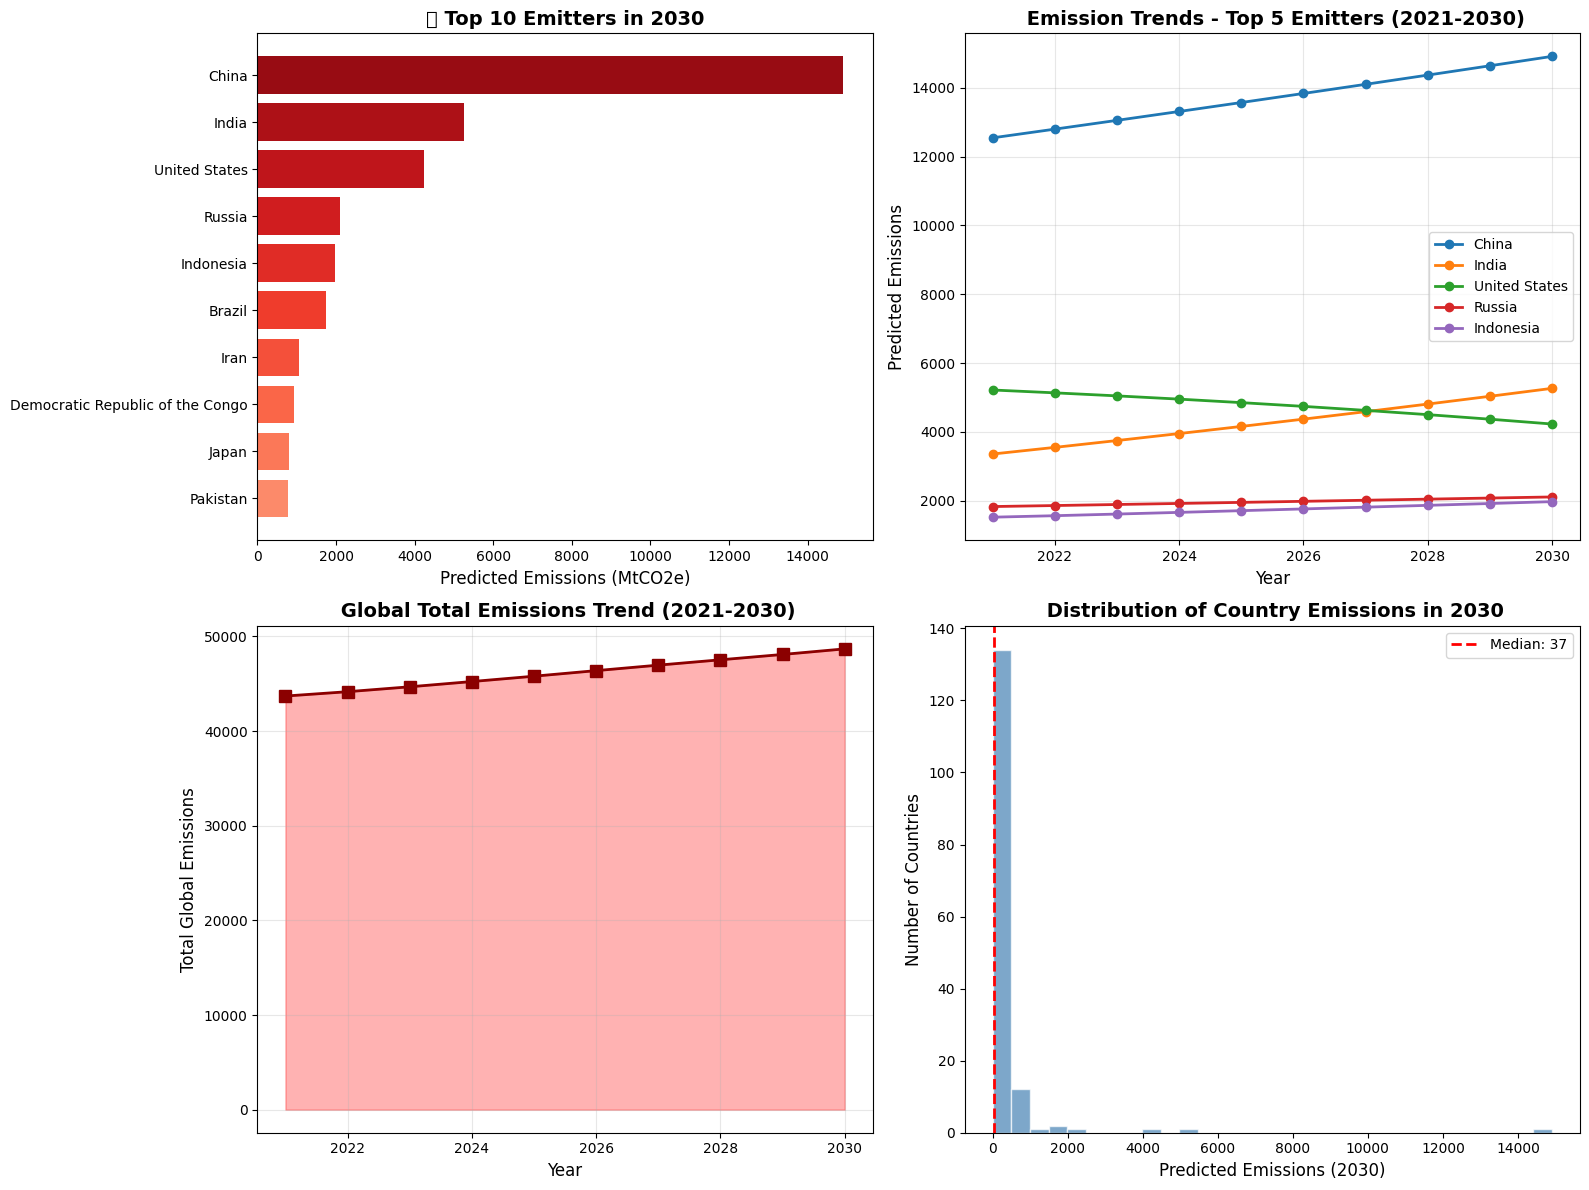

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 10 Emitters in 2030 (Bar Chart)
ax1 = axes[0, 0]
top10_data = predictions_df[predictions_df['Year'] == 2030].nlargest(10, 'Predicted_Emissions')
colors = plt.cm.Reds(np.linspace(0.4, 0.9, 10))[::-1]
ax1.barh(top10_data['Country'], top10_data['Predicted_Emissions'], color=colors)
ax1.set_xlabel('Predicted Emissions (MtCO2e)', fontsize=12)
ax1.set_title('🏆 Top 10 Emitters in 2030', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# 2. Emissions Trend for Top 5 Countries (2021-2030)
ax2 = axes[0, 1]
top5_countries = top10_data['ISO'].head(5).tolist()
for iso in top5_countries:
    country_data = predictions_df[predictions_df['ISO'] == iso]
    country_name = country_data['Country'].iloc[0]
    ax2.plot(country_data['Year'], country_data['Predicted_Emissions'], 
             marker='o', linewidth=2, markersize=6, label=country_name)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Predicted Emissions', fontsize=12)
ax2.set_title(' Emission Trends - Top 5 Emitters (2021-2030)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Global Total Emissions Trend
ax3 = axes[1, 0]
global_trend = predictions_df.groupby('Year')['Predicted_Emissions'].sum()
ax3.plot(global_trend.index, global_trend.values, marker='s', linewidth=2, 
         markersize=8, color='darkred')
ax3.fill_between(global_trend.index, global_trend.values, alpha=0.3, color='red')
ax3.set_xlabel('Year', fontsize=12)
ax3.set_ylabel('Total Global Emissions', fontsize=12)
ax3.set_title(' Global Total Emissions Trend (2021-2030)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Emissions Distribution in 2030
ax4 = axes[1, 1]
emissions_2030 = predictions_df[predictions_df['Year'] == 2030]['Predicted_Emissions']
ax4.hist(emissions_2030, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
ax4.axvline(emissions_2030.median(), color='red', linestyle='--', linewidth=2, 
            label=f'Median: {emissions_2030.median():,.0f}')
ax4.set_xlabel('Predicted Emissions (2030)', fontsize=12)
ax4.set_ylabel('Number of Countries', fontsize=12)
ax4.set_title(' Distribution of Country Emissions in 2030', fontsize=14, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.savefig('emissions_predictions_2030.png', dpi=300, bbox_inches='tight')
plt.show()